# **MINI-PROJECT-2 : Stock Price Prediction using RNN - LSTM**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase"

# install import-ipynb for importing helper modules
!pip install import-ipynb
import import_ipynb

# importing helper functions for data preprocessing and model visualization
import plotlib_helper as gplot
import datapreprocess_helper as dataprep

/content/drive/My Drive/P2_TimeForecast/P2_CodeBase
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=7e2f219eaa7e590caa22e99dd48bace695a49e80c600f61e047721bbee3fb263
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
importing Jupyter notebook from plotlib_helper.ipynb
importing Jupyter notebook from datapreprocess_helper.ipynb


In [3]:
data_path = "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase/data/"
dnn_path = "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase/dnn/"

## Load Data

In [4]:
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


filepath = os.path.join(data_path, "P2_Preprocessed_CNN_LSTM.csv")
df = pd.read_csv(filepath, na_values=['NA','?','-'])

print(df.dtypes , df.shape)
print()
print(df[0:5])
print()
print(df.isnull().sum())

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
Output    float64
dtype: object (4392, 6)

       Open      High       Low     Close    Volume    Output
0 -0.894209 -0.885022 -0.892306 -0.884364  1.104812  4.125000
1 -0.883762 -0.886056 -0.885975 -0.888021 -0.497301  4.015625
2 -0.887941 -0.889159 -0.887558 -0.888543 -0.892217  4.000000
3 -0.887941 -0.890194 -0.891251 -0.893768 -0.000263  3.843750
4 -0.896820 -0.898986 -0.906551 -0.908920  3.729366  3.390625

Open      0
High      0
Low       0
Close     0
Volume    0
Output    0
dtype: int64


## Split dataframe into features and target

In [5]:
y = df['Output'].copy() # y is copy of close column
x = df.drop(columns=['Output'], axis= 1, inplace=False)


x = x.to_numpy(dtype="float32");
y = y.to_numpy(dtype="float32");
x[0:5]
print(x.shape, y.shape)


(4392, 5) (4392,)


## Converting array into 3D array for LSTM using to_sequence()

In [6]:
import numpy as np

def to_sequences(seq_size, input, target):
    x = []
    y = []

    for i in range(len(target)-seq_size-1):
        window = input[i:(i+seq_size)]
        after_window = target[i+seq_size]
        window = [x for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [7]:
# each record is converted into 7X5 array
SEQ_SIZE = 7
x,y = to_sequences(SEQ_SIZE, x, y)
print(x.shape , y.shape)

(4384, 7, 5) (4384,)


## Splitting array into train & test set (70-30)

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=120)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print()
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))

x_train shape: (3068, 7, 5)
x_test shape: (1316, 7, 5)
y_train shape: (3068,)
y_test shape: (1316,)

Training samples: 3068
Test samples: 1316


## Training, Fitting and Model Evaluation for LSTM model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=ip_size))
  model.add(Dense(32))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00014: early stopping
Epoch 00010: early stopping
Epoch 00009: early stopping
Epoch 00020: early stopping
Epoch 00008: early stopping
Elapsed time: 39.86591124534607


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 20,033
Trainable params: 20,033
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN -- with LSTM  --------

RMSE         : 1.174554
MSE          : 1.379577
R2 score     : 0.9983201457586907

-------- Regression Chart --------


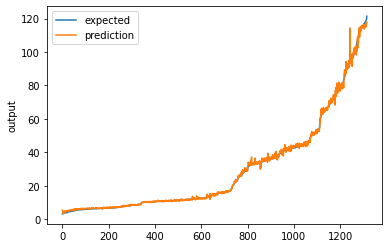

In [12]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN -- with LSTM")
print()
gplot.chart_regression(pred.flatten(),y_test)